Note, still in the process of experimenting with parameters

Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [2]:
data = pds.read_pickle('added_t_ttjs.pkl')

In [2]:
data = pds.read_pickle('dataset_model3v2_history.pkl')

In [3]:
data.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,label,t,ttjs
0,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,72,71.0,0
1,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,72,70.0,0
2,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,72,69.0,0
3,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,72,68.0,0
4,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,72,67.0,0


Import data

One hot encode segments, normalize columns and create final dataset

In [4]:
df = data

In [9]:
dataset = pds.DataFrame()
# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

# Make segments categorical
dataset['segment_number'] = (df['segment_number']-df['segment_number'].min())/(df['segment_number'].max()-df['segment_number'].min())#pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.dt.hour*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.dt.hour*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
# Previousla was 'time_since_journey_start'
dataset['ttjs'] = (df['ttjs']-df['ttjs'].min())/(df['ttjs'].max()-df['ttjs'].min())

dataset['lat'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['lon'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())


# If you don't want to train on the first segment
#skip_first = dataset[dataset[1] == 0].index
#dataset = dataset.loc[skip_first].reset_index().drop(columns=['index'])
#df = df.loc[skip_first].reset_index().drop(columns=['index'])

dataset.head()

,journey_number,segment_number,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,lat,lon
0,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326317,0.924521
1,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326237,0.925287
2,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326156,0.925670
3,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326076,0.926437
4,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326116,0.926437


Add columns for the three latest positions for each sample. Replace the first sample from each journey with itself.

In [10]:
new_speed = pds.DataFrame(0, index=np.arange(len(dataset)), columns=['speed_one', 'speed_two', 'speed_three'])

In [11]:
newcol = pds.DataFrame(0, index=np.arange(len(dataset)), columns=['lat_one', 'lon_one', 'lat_two', 'lon_two', 'lat_three', 'lon_three'])

In [12]:
for i, a in dataset.groupby('journey_number'):
    idxs = a.index
    
    newcol.lat_one.iloc[idxs] = a.lat.shift(1)
    newcol.lat_one.iloc[idxs[0]] = newcol.lat_one.iloc[1]

    newcol.lon_one.iloc[idxs] = a.lon.shift(1)
    newcol.lon_one.iloc[idxs[0]] = newcol.lon_one.iloc[1]

    newcol.lat_two.iloc[idxs] = a.lat.shift(2)
    newcol.lat_two.iloc[idxs[0]] = newcol.lat_two.iloc[2]
    newcol.lat_two.iloc[idxs[1]] = newcol.lat_two.iloc[2]

    newcol.lon_two.iloc[idxs] = a.lon.shift(2)
    newcol.lon_two.iloc[idxs[0]] = newcol.lon_two.iloc[2]
    newcol.lon_two.iloc[idxs[1]] = newcol.lon_two.iloc[2] 
   
    newcol.lat_three.iloc[idxs] = a.lat.shift(3)
    newcol.lat_three.iloc[idxs[0]] = newcol.lat_three.iloc[3]
    newcol.lat_three.iloc[idxs[1]] = newcol.lat_three.iloc[3]
    newcol.lat_three.iloc[idxs[2]] = newcol.lat_three.iloc[3]

    newcol.lon_three.iloc[idxs] = a.lon.shift(3)
    newcol.lon_three.iloc[idxs[0]] = newcol.lon_three.iloc[3]
    newcol.lon_three.iloc[idxs[1]] = newcol.lon_three.iloc[3] 
    newcol.lon_three.iloc[idxs[2]] = newcol.lon_three.iloc[3] 

c:\users\jacke\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
for i, a in dataset.groupby('journey_number'):
    idxs = a.index
    
    new_speed.speed_one.iloc[idxs] = a.lat.shift(1)
    new_speed.speed_one.iloc[idxs[0]] = new_speed.speed_one.iloc[1]

    new_speed.speed_two.iloc[idxs] = a.lat.shift(2)
    new_speed.speed_two.iloc[idxs[0]] = new_speed.speed_two.iloc[2]
    new_speed.speed_two.iloc[idxs[1]] = new_speed.speed_two.iloc[2]
   
    new_speed.speed_three.iloc[idxs] = a.lat.shift(3)
    new_speed.speed_three.iloc[idxs[0]] = new_speed.speed_three.iloc[3]
    new_speed.speed_three.iloc[idxs[1]] = new_speed.speed_three.iloc[3]
    new_speed.speed_three.iloc[idxs[2]] = new_speed.speed_three.iloc[3]


Make sure there are no NaN:s produced by shifting

In [16]:
new_speed.isna().sum()

speed_one      0
speed_two      0
speed_three    0
dtype: int64

In [17]:
newcol.isna().sum()

lat_one      0
lon_one      0
lat_two      0
lon_two      0
lat_three    0
lon_three    0
dtype: int64

Absove should be 0

In [18]:
new_speed.head()

,speed_one,speed_two,speed_three
0,0.326317,0.326317,0.326317
1,0.326317,0.326317,0.326317
2,0.326237,0.326317,0.326317
3,0.326156,0.326237,0.326317
4,0.326076,0.326156,0.326237


In [19]:
n_dataset = pds.concat([dataset, newcol], axis=1)

In [20]:
n_dataset = pds.concat([n_dataset, new_speed], axis=1)

In [21]:
n_dataset.head()

,journey_number,segment_number,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,lat,lon,lat_one,lon_one,lat_two,lon_two,lat_three,lon_three,speed_one,speed_two,speed_three
0,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326317,0.924521,0.326317,0.924521,0.326317,0.924521,0.326317,0.924521,0.326317,0.326317,0.326317
1,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326237,0.925287,0.326317,0.924521,0.326317,0.924521,0.326317,0.924521,0.326317,0.326317,0.326317
2,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326156,0.925670,0.326237,0.925287,0.326317,0.924521,0.326317,0.924521,0.326237,0.326317,0.326317
3,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326076,0.926437,0.326156,0.925670,0.326237,0.925287,0.326317,0.924521,0.326156,0.326237,0.326317
4,1,0.0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326116,0.926437,0.326076,0.926437,0.326156,0.925670,0.326237,0.925287,0.326076,0.326156,0.326237


In [22]:
list(n_dataset)

['journey_number',
 'segment_number',
 'hr_sin',
 'hr_cos',
 'dir_sin',
 'dir_cos',
 'speed',
 'ttjs',
 'lat',
 'lon',
 'lat_one',
 'lon_one',
 'lat_two',
 'lon_two',
 'lat_three',
 'lon_three',
 'speed_one',
 'speed_two',
 'speed_three']

In [23]:
dataset = n_dataset.reset_index().drop(columns=['index'])

In [13]:
dataset.to_pickle('dataset_model3v2_history.pkl')

Select an arbitrary number of test journeys

In [39]:
# Roughly 20%
num_test_segments = 700 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, 80% training data

In [40]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['t'][~mask]
test_labels = df['t'][mask]

In [41]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [42]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.tanh, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu),
    keras.layers.Dense(len(train_data.columns)),
    #keras.layers.Dense(len(train_data.columns)),
    #keras.layers.Dense(len(train_data.columns)),
    #keras.layers.Dense(len(train_data.columns)),
	keras.layers.Dense(1)
	])

#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae', 'mape', 'mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_7 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
None


Fit model, 10% of the training data is used as validation set

In [43]:
EPOCHS=20
# Initial_epoch can be set to resume training after preciously run epochs
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 2479891 samples, validate on 275544 samples
Epoch 1/20
2479891/2479891 [==============================] - 63s 26us/step - loss: 13.2747 - mean_absolute_error: 13.2747 - mean_absolute_percentage_error: 119709311.7751 - mean_squared_error: 600.5555 - val_loss: 12.6734 - val_mean_absolute_error: 12.6734 - val_mean_absolute_percentage_error: 54373272.3294 - val_mean_squared_error: 576.5141
Epoch 2/20
2479891/2479891 [==============================] - 62s 25us/step - loss: 12.1643 - mean_absolute_error: 12.1643 - mean_absolute_percentage_error: 46411135.1982 - mean_squared_error: 557.3247 - val_loss: 12.0637 - val_mean_absolute_error: 12.0637 - val_mean_absolute_percentage_error: 26634437.8978 - val_mean_squared_error: 563.7868
Epoch 3/20
2479891/2479891 [==============================] - 62s 25us/step - loss: 11.9593 - mean_absolute_error: 11.9593 - mean_absolute_percentage_error: 32969473.1962 - mean_squared_error: 551.2078 - val_loss: 12.0217 - val_mean_absolute_error: 12.0217 -

Save model to disk

In [ ]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model2v2.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# Serialize weights to HDF5
model.save_weights("model2v2.h5")

Load model example

In [ ]:
# Load YAML and create model
yaml_file = open('model2v2.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights("model2v2.h5")

In [ ]:
#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

## Evaluate model on all segments 

Evaluate model

In [29]:
model.evaluate(test_data.values, test_labels.values)

587963/587963 [==============================] - 6s 9us/step


[12.011664635032998, 12.011664635032998, 60831474.72974712, 531.6523020745395]

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [30]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

941/941 [==============================] - 0s 216us/step


In [31]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels_ = test_labels.loc[journey_]
j_labels = j_labels_.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


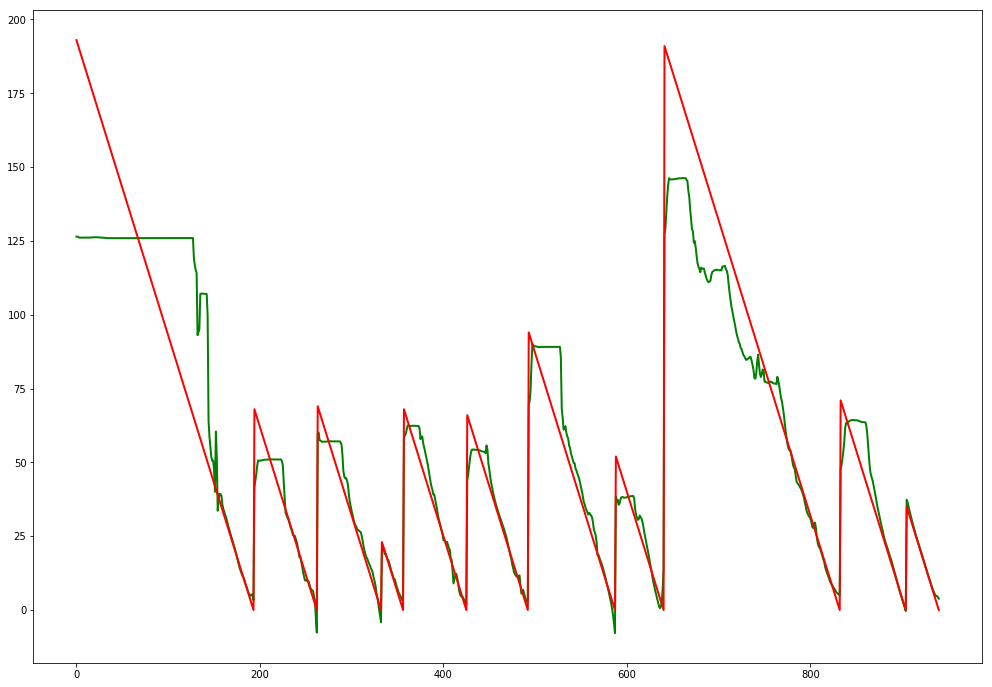

941/941 [==============================] - 0s 65us/step
[11.099064376731734, 11.099064376731734, 57450943.1984244, 342.00316534285594]


In [32]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(model_to_predict.values, j_labels_.values))

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [35]:
# Drop first segment, all journeys
test_ign = test_data[test_data['segment_number'] == 0].index
test_ign_d = test_data.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

# Drop first segment, single journey

# Selected journey needs to be in the msk array
# selected_journey = np.random.choice(msk)

# Selected_journey from previous example should be used to compare loss

test_single_j = test_input[test_input['journey_number'] == selected_journey]
to_test = test_single_j.drop(columns=['journey_number'])

test_single = to_test[to_test['segment_number'] == 0].index
test_single_d = to_test.loc[test_single]
journey_ = test_labels[test_input['journey_number'] == selected_journey]
test_single_l = journey_.loc[test_single]
test_single_l = test_single_l.reset_index().drop(columns=['index'])

Evaluate model on all data

In [36]:
model.evaluate(test_ign_d.values, test_ign_l.values)

122191/122191 [==============================] - 1s 9us/step


[29.429229276451736,
 29.429229276451736,
 14448053.672249082,
 1847.6907073493117]

About 7 seconds m.a.e. Really good to drop the first segment!

In [37]:
predictions = model.predict(test_single_d.values, batch_size=1, verbose=1)

194/194 [==============================] - 0s 206us/step


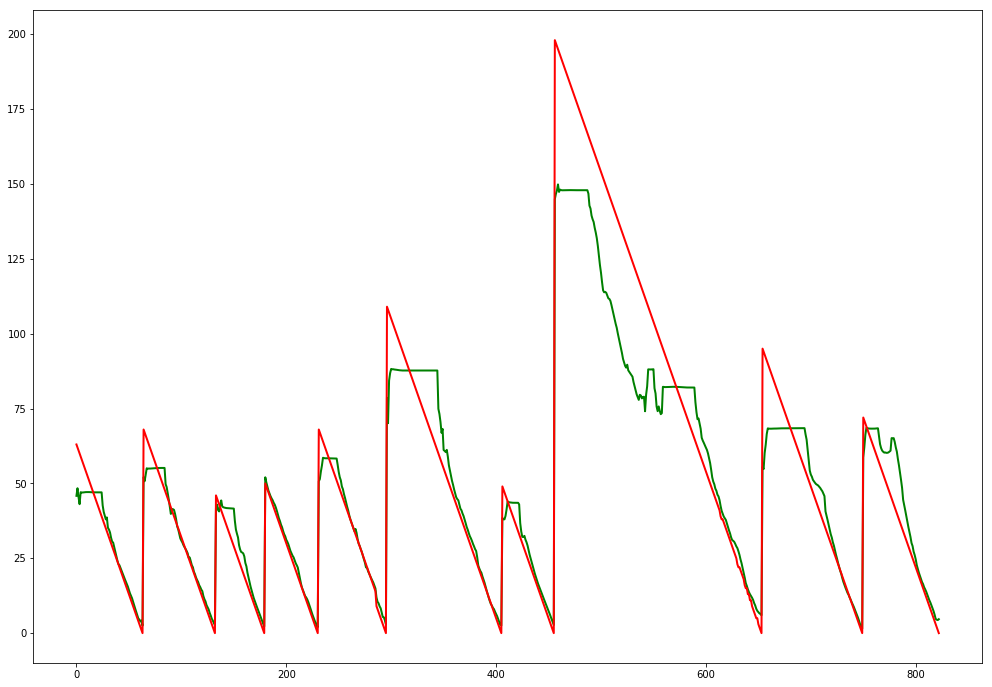

823/823 [==============================] - 0s 16us/step
[8.61079743160512, 8.61079743160512, 36046425.99836883]


In [174]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(test_single_d.values, test_single_l.values))

It is easy to see that it has troubles dealing with dwell time at bus stops.

Below is a final scatterplot from the entire test data set. But this is very hard to interpret.

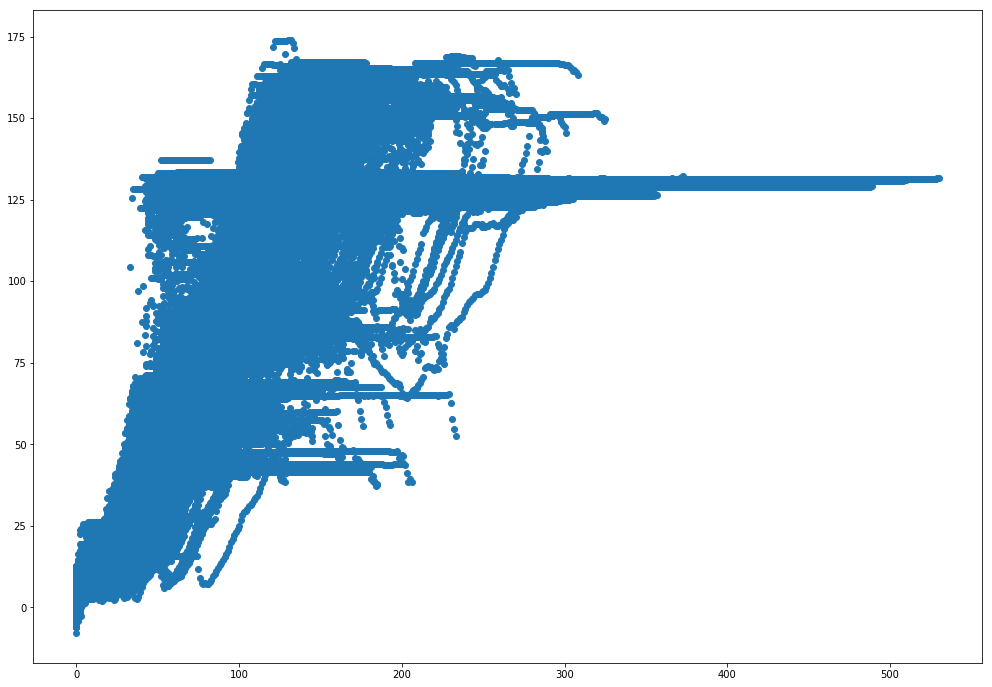

In [175]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()

## Now, lets look only at segment 9 (McD to Gamla Linköping)

In [176]:
# Drop first segment, all journeys
test_ign = test_input[test_input[9] == 1].index
test_ign_d = test_input.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]
#test_ign_l = test_ign_l.reset_index().drop(columns=['index'])

In [177]:
eval_data = [] #pds.DataFrame()
eval_labels = [] #pds.DataFrame()

for i, seg in test_ign_d.groupby('journey_number'):
    n_seg = seg.drop(columns=['journey_number'])
    n_idx = n_seg.index
    pred = model.predict(n_seg, verbose=0)
    eval_data.append([pred])
    eval_labels.append([test_ign_l.loc[n_idx].reset_index().drop(columns=['index'])])
    #eval_data = pds.concat(eval_data, pred)
    #eval_labels = pds.concat(eval_labels, test_ign_l.loc[n_idx].reset_index().drop(columns=['index']), axis=2)

Looking att all predictions at the same time shows interesting results! Some journeys (the rightmost) seems to have large troubles with 

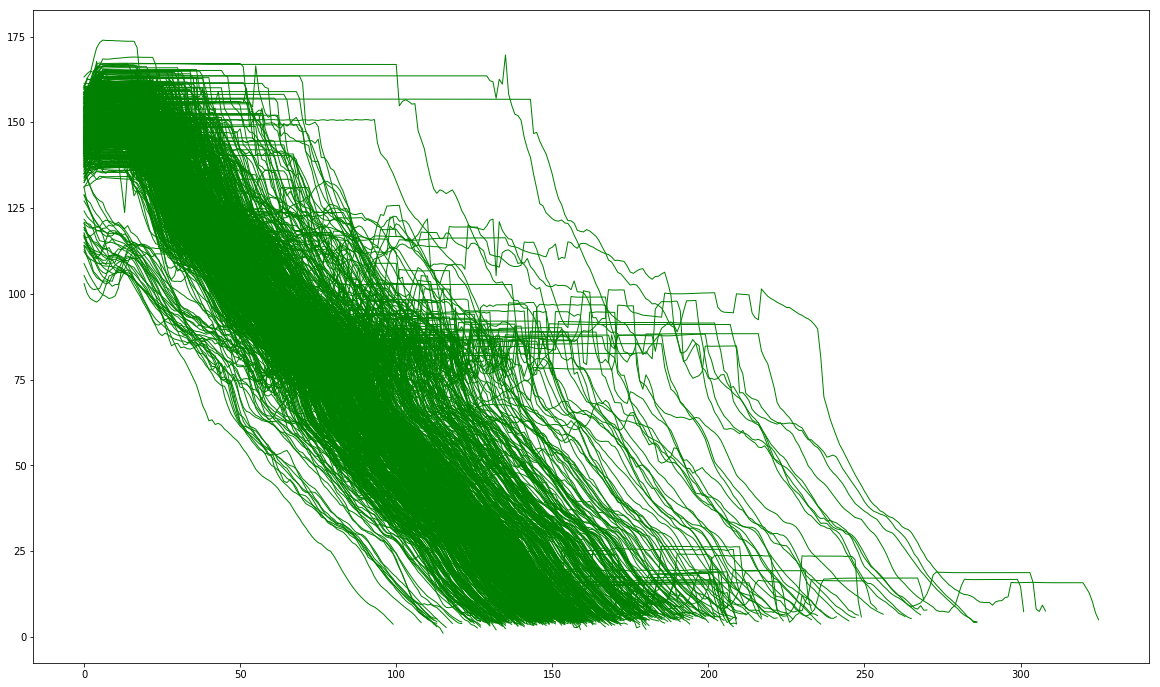

In [178]:
plt.rcParams['figure.figsize'] = [20, 12]
for i in range(len(eval_data)):
    plt.plot(eval_data[i][0], color='green', linewidth=1, markersize=2)
    #plt.plot(eval_labels[i][0], color='red', linewidth=2, markersize=12)
plt.show()
#print(model.evaluate(test_ign_d.values, test_ign_l.values))

There seems to be large variance in this segment. This is the segment containing Vallarondellen, which is known for having large traffic issues during rush hours. This is probably why some journeys are very far to the right and the actual travel time ranges from 100-350 seconds.

## Adding a Kalman filter to the mix

A general function is created to do this. As the data is as it is - all segments on a trip smashed together, it means that it could impact performance when changing segments. To combat this, calculations are done per segment.